In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
# Create a new embedding model that recieves an image as input and outputs an embedding vector.
def embedding_model(input_shape): # (224, 224, 3)

  # Use a pretrained model(ResNet50 in our case) for feature extraction.
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

  # Freeze the layers of the pretrained model.
  for layer in base_model.layers:
      layer.trainable = False

  # Add extra layers on top of the pretrained model.
  x = tf.keras.layers.Conv2D(filters = 512, kernel_size = 1, activation = 'relu', padding = 'same')(base_model.output)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)

  # Create and return the model.
  model = tf.keras.models.Model(base_model.input, x)
  return model

In [ ]:
# Create the siamese network model that receives two input images and calculates
# the distance between the embeddings of those two images and based on the distance
# outputs if those two images are the same(the same person in our case).

def siamese_network(input_shape):
    
    # Receive two images as inputs.
    left_input = layers.Input(shape=input_shape)
    right_input = layers.Input(shape=input_shape)

    # Create an instance of the embedding model.
    model = embedding_model(input_shape)

    # Pass two images through the embedding model.
    left = model(left_input)
    right = model(right_input)

    # Create a custom layer that calculates the distance between two vectors.
    distance_layer = layers.Lambda(lambda x: tf.math.abs(x[0] - x[1]))

    # Calculate the distance between two embeddings by passing them through the distance layer.
    distance = distance_layer([left, right])

    # Output layer that is supposed to determine whether the two images are of the same person.
    output_layer = layers.Dense(1, activation='sigmoid')(distance)

    # Create and return the siamese network model.
    siamese_model = tf.keras.models.Model(inputs=[left_input, right_input], outputs=[output_layer, distance])
    return siamese_model

In [ ]:
sn = siamese_network((224,224,3))
sn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 128)          27848192    ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

In [ ]:
def preprocess_single_image(path):
  image = tf.io.read_file(path)

  image = tf.io.decode_jpeg(image)

  image = tf.image.resize(image, (224,224))

  image = image/255
  return image

def preprocess(first_img, second_img, label):
  return(preprocess_single_image(first_img), preprocess_single_image(second_img), label)

In [ ]:
anchor_directory = '/content/drive/MyDrive/bachelor_project/data/anchor'
address_list = []
for folder in os.listdir(anchor_directory):
  for filename in os.listdir(anchor_directory + '/'+ folder):
    address_list.append(anchor_directory + '/' + folder + '/' + filename)
    
anchor = tf.data.Dataset.from_tensor_slices(address_list)


positive_directory = '/content/drive/MyDrive/bachelor_project/data/positive'
address_list_1 = []
for folder in os.listdir(positive_directory):
  for filename in os.listdir(positive_directory + '/'+ folder):
    address_list_1.append(positive_directory + '/' + folder + '/' + filename)
    
positive = tf.data.Dataset.from_tensor_slices(address_list_1)


negative_directory = '/content/drive/MyDrive/bachelor_project/data/negative'
negative = tf.data.Dataset.list_files(negative_directory+'/*.jpg')

In [ ]:
len(negative), len(positive), len(anchor)

(61, 61, 61)

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
data = data.map(preprocess)
data = data.shuffle(len(data))
data = data.batch(8)
train_data = data.take(int(len(data) * 0.8))
val_data = data.skip(int(len(data) * 0.8))

len(data), len(train_data), len(val_data)

(16, 12, 4)

label for the first row is: 0.0
label for the second row is: 1.0


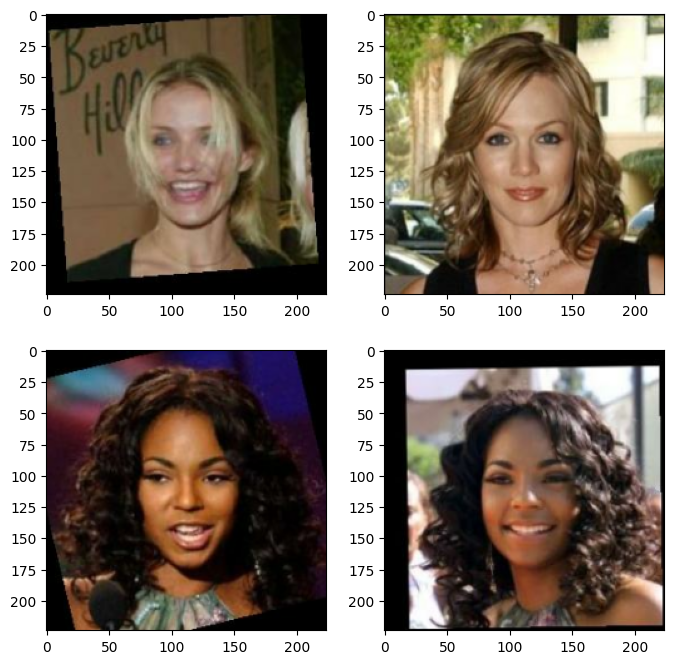

In [ ]:
# Visualize your data
one_batch = next(iter(data))
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0,0].imshow(one_batch[0][0])
axs[0,1].imshow(one_batch[1][0])
axs[1,0].imshow(one_batch[0][1])
axs[1,1].imshow(one_batch[1][1])
print(f'label for the first row is: {one_batch[2][0].numpy()}')
print(f'label for the second row is: {one_batch[2][1].numpy()}')



In [ ]:
loss_fn = tf.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [ ]:
def train_step(model, single_batch, loss_fn, optimizer):
  
  with tf.GradientTape() as tape:
    
    X = single_batch[:2] # two images
    y = single_batch[2] # label(-1- if same person and -0- otherwise)

    # forward pass
    y_pred,_ = model(X, training = True)
    # calculate the loss
    loss = loss_fn(y, y_pred)
  # calculate gradients
  grad = tape.gradient(loss, model.trainable_variables)
  
  # update weights via gradient descent
  optimizer.apply_gradients(zip(grad, model.trainable_variables))

  return loss, y_pred




def train(model, train_data, validation_data, num_epochs, loss_fn, optimizer):

  loss_history_per_epoch = []
  accuracy_history_per_epoch = []
  val_loss_history_per_epoch = []
  val_accuracy_history_per_epoch = []

  ####################### training loop and calculation of the train loss and accuracy #######################
  for epoch in range(num_epochs): 
    batch_losses = []
    val_batch_losses = []
    m1 = tf.keras.metrics.Accuracy()
    # Print what epoch you are at.
    print(f'\n Epoch {epoch+1}/{num_epochs}')
    # Progress bar to see the progress.
    progress_bar = tf.keras.utils.Progbar(len(train_data))

    for idx, batch in enumerate(train_data):
      # keep track of the loss of each batch
      loss_per_batch, yHat_per_batch = train_step(model, batch, loss_fn, optimizer)
      batch_losses.append(loss_per_batch)
      m1.update_state(tf.expand_dims(batch[2], axis=1), tf.round(yHat_per_batch))
      progress_bar.update(idx + 1)

    # keep track of the loss and accuracy per epoch.
    loss_history_per_epoch.append(float(np.mean(np.array(batch_losses))))
    accuracy_history_per_epoch.append(float(m1.result().numpy()))
    ###########################################################################################################
    
    ####################### evaluation per epoch on validation set ######################
    if validation_data is not None:
      m2 = tf.keras.metrics.Accuracy()
      for test_batch in validation_data:
        yHat_test_per_batch,_ = model(test_batch[:2])
        val_loss_per_batch = loss_fn(test_batch[2], yHat_test_per_batch)
        val_batch_losses.append(val_loss_per_batch)
        m2.update_state(tf.expand_dims(test_batch[2], axis=1), tf.round(yHat_test_per_batch))

      # keep track of the validation loss and accuracy per epoch.
      val_loss_history_per_epoch.append(float(np.mean(np.array(val_batch_losses))))
      val_accuracy_history_per_epoch.append(float(m2.result().numpy()))
    ######################################################################################
    
    ####################### print the loss and accuracy ########################
    print(f'loss: {loss_history_per_epoch[epoch]}, accuracy: {accuracy_history_per_epoch[epoch]}')
    if validation_data is not None:
      print(f'val_loss: {val_loss_history_per_epoch[epoch]}, val_accuracy: {val_accuracy_history_per_epoch[epoch]}')
    #######################################################################################

    ####################### return history object #########################
  if validation_data is not None:
    return {'loss_history':loss_history_per_epoch,
            'accuracy_history':accuracy_history_per_epoch,
            'validation_loss_history':val_loss_history_per_epoch,
            'validation_accuracy_history':val_accuracy_history_per_epoch}
  return {'loss_history':loss_history_per_epoch,
          'accuracy_history':accuracy_history_per_epoch}
  


In [ ]:
history = train(sn,train_data,val_data,3,loss_fn,optimizer)


 Epoch 1/3
10/10 [==============================] - 171s 16s/step
loss: 0.8278127908706665, accuracy: 0.30000001192092896
val_loss: 0.5684167742729187, val_accuracy: 0.762499988079071

 Epoch 2/3
10/10 [==============================] - 167s 16s/step
loss: 0.5715022683143616, accuracy: 0.7250000238418579
val_loss: 0.5498272776603699, val_accuracy: 0.800000011920929

 Epoch 3/3
10/10 [==============================] - 126s 13s/step
loss: 0.5712305307388306, accuracy: 0.7875000238418579
val_loss: 0.4646628499031067, val_accuracy: 0.8125


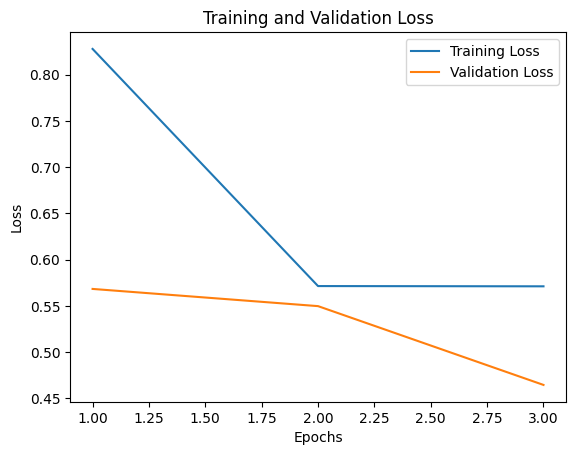

In [ ]:
from numpy import arange

num_epochs = 3

# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(1, num_epochs + 1)
 
# Plot and label the training and validation loss values
plt.plot(epochs_range, history['loss_history'], label='Training Loss')
plt.plot(epochs_range, history['validation_loss_history'], label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
# plt.xticks(arange(0, num_epochs+1, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

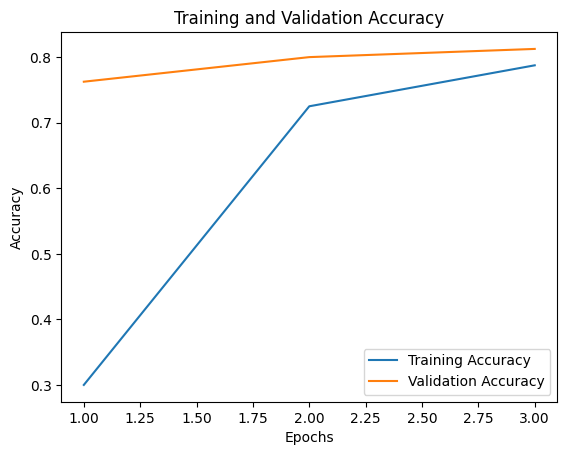

In [ ]:
from numpy import arange

num_epochs = 3

# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(1, num_epochs + 1)
 
# Plot and label the training and validation loss values
plt.plot(epochs_range, history['accuracy_history'], label='Training Accuracy')
plt.plot(epochs_range, history['validation_accuracy_history'], label='Validation Accuracy')
 
# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
 
# Set the tick locations
# plt.xticks(arange(0, num_epochs+1, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
# base_model.summary()

## Going modular


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
import os
import tensorflow as tf

def preprocess_single_image(path):

  '''This function receives a path to an image and then returns a preprocessed image
  which can be used to train the model.'''

  # Read the image into a variable.
  image = tf.io.read_file(path)
  # decode the jgp image into a tensor.
  image = tf.io.decode_jpeg(image)
  # Resize the images to a specific size.
  image = tf.image.resize(image, (224,224))
  # map the image pixels between 0-1
  image = image/255
  return image

def preprocess(first_img, second_img, label):
  '''This function is the one that we directly call for preprocessing our images. because we have 
  two images and a label we pass them to this function and get back a tuple of two preprocessed 
  images and the corresponding label'''
  return(preprocess_single_image(first_img), preprocess_single_image(second_img), label)

def create_dataset(anchor_dir, positive_dir, negative_dir, train_split, batch_size):
  '''

  call this function with the necessary arguments (which their names are pretty intuitive and
  self_explanatory) to get a train and a validation tensorflow dataset to train a siamese network.
   the shape of each batch of the dataset will be like this:
       anchor_images             other_images          labels
  ((batch_size,224,224,3), (batch_size,224,224,3), (batch_size,1))

  here are the paths I used:

  anchor_dir = '/content/drive/MyDrive/bachelor_project/data/anchor'
  positive_dir = '/content/drive/MyDrive/bachelor_project/data/positive'
  negative_dir = '/content/drive/MyDrive/bachelor_project/data/negative'

  '''
  address_list = []
  for folder in os.listdir(anchor_dir):
    for filename in os.listdir(anchor_dir + '/'+ folder):
      address_list.append(anchor_dir + '/' + folder + '/' + filename)
      
  anchor = tf.data.Dataset.from_tensor_slices(address_list)


  address_list_1 = []
  for folder in os.listdir(positive_dir):
    for filename in os.listdir(positive_dir + '/'+ folder):
      address_list_1.append(positive_dir + '/' + folder + '/' + filename)
      
  positive = tf.data.Dataset.from_tensor_slices(address_list_1)


  negative = tf.data.Dataset.list_files(negative_dir+'/*.jpg')

  positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
  negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
  data = positives.concatenate(negatives)

  data = data.map(preprocess)
  data = data.shuffle(len(data))
  data = data.batch(batch_size)
  train_data = data.take(int(len(data) * train_split))
  val_data = data.skip(int(len(data) * train_split))

  return train_data, val_data

In [3]:
import tensorflow as tf
import numpy as np

def train_step(model, single_batch, loss_fn, optimizer):

  '''Trains the model on a single batch of data.
  this function will be used inside the main train function'''
  
  with tf.GradientTape() as tape:
    
    X = single_batch[:2] # two images
    y = single_batch[2] # label(-1- if same person and -0- otherwise)

    # forward pass
    y_pred,_ = model(X, training = True)
    # calculate the loss
    loss = loss_fn(y, y_pred)
  # calculate gradients
  grad = tape.gradient(loss, model.trainable_variables)
  
  # update weights via gradient descent
  optimizer.apply_gradients(zip(grad, model.trainable_variables))

  return loss, y_pred


def train(model, train_data, validation_data, num_epochs, loss_fn, optimizer):

  '''
  
  Call this function to train a siamese network model.
  for example:
  history = train(sn,train_data,val_data,3,tf.losses.BinaryCrossentropy(),tf.keras.optimizers.Adam())
  it returns a dictionary of loss and accuracy histories during training.

  '''
  loss_history_per_epoch = []
  accuracy_history_per_epoch = []
  val_loss_history_per_epoch = []
  val_accuracy_history_per_epoch = []

  ####################### training loop and calculation of the train loss and accuracy #######################
  for epoch in range(num_epochs): 
    batch_losses = []
    val_batch_losses = []
    m1 = tf.keras.metrics.Accuracy()
    # Print what epoch you are at.
    print(f'\n Epoch {epoch+1}/{num_epochs}')
    # Progress bar to see the progress.
    progress_bar = tf.keras.utils.Progbar(len(train_data))

    for idx, batch in enumerate(train_data):
      # keep track of the loss of each batch
      loss_per_batch, yHat_per_batch = train_step(model, batch, loss_fn, optimizer)
      batch_losses.append(loss_per_batch)
      m1.update_state(tf.expand_dims(batch[2], axis=1), tf.round(yHat_per_batch))
      progress_bar.update(idx + 1)

    # keep track of the loss and accuracy per epoch.
    loss_history_per_epoch.append(float(np.mean(np.array(batch_losses))))
    accuracy_history_per_epoch.append(float(m1.result().numpy()))
    ###########################################################################################################
    
    ####################### evaluation per epoch on validation set ######################
    if validation_data is not None:
      m2 = tf.keras.metrics.Accuracy()
      for test_batch in validation_data:
        yHat_test_per_batch,_ = model(test_batch[:2])
        val_loss_per_batch = loss_fn(test_batch[2], yHat_test_per_batch)
        val_batch_losses.append(val_loss_per_batch)
        m2.update_state(tf.expand_dims(test_batch[2], axis=1), tf.round(yHat_test_per_batch))

      # keep track of the validation loss and accuracy per epoch.
      val_loss_history_per_epoch.append(float(np.mean(np.array(val_batch_losses))))
      val_accuracy_history_per_epoch.append(float(m2.result().numpy()))
    ######################################################################################
    
    ####################### print the loss and accuracy ########################
    print(f'loss: {loss_history_per_epoch[epoch]}, accuracy: {accuracy_history_per_epoch[epoch]}')
    if validation_data is not None:
      print(f'val_loss: {val_loss_history_per_epoch[epoch]}, val_accuracy: {val_accuracy_history_per_epoch[epoch]}')
    #######################################################################################

    ####################### return the history object #########################
  if validation_data is not None:
    return {'loss_history':loss_history_per_epoch,
            'accuracy_history':accuracy_history_per_epoch,
            'validation_loss_history':val_loss_history_per_epoch,
            'validation_accuracy_history':val_accuracy_history_per_epoch}
  return {'loss_history':loss_history_per_epoch,
          'accuracy_history':accuracy_history_per_epoch}
  


In [4]:
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet import ResNet50

def embedding_model(input_shape): # (224, 224, 3)
  '''
  
  this function turn our two images into two vectors and calcuates their
  distance and returns one single vector of distance
  
  '''

  # Use a pretrained model(ResNet50 in our case) for feature extraction.
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

  # Freeze the layers of the pretrained model.
  for layer in base_model.layers:
      layer.trainable = False

  # Add extra layers on top of the pretrained model.
  x = tf.keras.layers.Conv2D(filters = 512, kernel_size = 1, activation = 'relu', padding = 'same')(base_model.output)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)

  # Create and return the model.
  model = tf.keras.models.Model(base_model.input, x)
  return model

def siamese_network(input_shape): # (224, 224, 3)
  '''
  
  this function returns the siamese network model that I used.
  you can check out the model by .summary() method after you put the model
  in a variable.

  '''
  
  # Receive two images as inputs.
  left_input = layers.Input(shape=input_shape)
  right_input = layers.Input(shape=input_shape)

  # Create an instance of the embedding model.
  model = embedding_model(input_shape)

  # Pass two images through the embedding model.
  left = model(left_input)
  right = model(right_input)

  # Create a custom layer that calculates the distance between two vectors.
  distance_layer = layers.Lambda(lambda x: tf.math.abs(x[0] - x[1]))

  # Calculate the distance between two embeddings by passing them through the distance layer.
  distance = distance_layer([left, right])

  # Output layer that is supposed to determine whether the two images are of the same person.
  output_layer = layers.Dense(1, activation='sigmoid')(distance)

  # Create and return the siamese network model.
  siamese_model = tf.keras.models.Model(inputs=[left_input, right_input], outputs=[output_layer, distance])
  return siamese_model

In [5]:
train_data, val_data = create_dataset(anchor_dir = '/content/drive/MyDrive/bachelor_project/data/anchor',
               positive_dir = '/content/drive/MyDrive/bachelor_project/data/positive',
               negative_dir = '/content/drive/MyDrive/bachelor_project/data/negative',
               train_split = 0.8,
               batch_size = 8)

len(train_data), len(val_data)

(12, 4)

In [6]:
sn = siamese_network((224,224,3))
sn.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 128)          27848192    ['input_1[0][0]',                
                           

In [7]:
loss_fn = tf.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()
history = train(sn,train_data,val_data,3,loss_fn,optimizer)


 Epoch 1/3
12/12 [==============================] - 136s 9s/step
loss: 0.7958539128303528, accuracy: 0.46875
val_loss: 0.6617426872253418, val_accuracy: 0.6666666865348816

 Epoch 2/3
12/12 [==============================] - 104s 9s/step
loss: 0.6999196410179138, accuracy: 0.6041666865348816
val_loss: 0.5111010670661926, val_accuracy: 0.75

 Epoch 3/3
12/12 [==============================] - 106s 9s/step
loss: 0.5699679851531982, accuracy: 0.7395833134651184
val_loss: 0.3850419521331787, val_accuracy: 0.8854166865348816
